# Importar librerías necesarias y definir variables

In [15]:
import json

from typing import List
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import os
from enum import Enum

from src.catching import attempt_catch
from src.pokemon import PokemonFactory, StatusEffect, Pokemon

DEFAULT_NOISE = 0  # Dijeron que no lo usemos, salvo para el 2c y no sé si el 2d

OUTPUT_PATH = "output"  # Relativo al src

CONFIG_PATH = "configs"

EJ2_CONFIG = "Ej2c.json"

class OutputFilenames(Enum): 
    # Relativo al output
    EJ1A = "ej1a.csv"
    EJ1B = "ej1b.csv"


CONFIG_FILENAME = "config.json" # Relativo al src

OUTPUT_HTML_PLOT_NAME = "first_figure.html"

In [11]:
def get_src() -> Path:
    return Path(get_src_str())


def get_src_str() -> str:
    return os.getcwd() + "/"


def move_to_src() -> None:
    src = get_src()
    os.chdir(src)


def get_output_dir() -> Path:
    return Path(get_src()).joinpath(OUTPUT_PATH)


def get_output_dir_str() -> str:
    return str(get_output_dir().resolve()) + "/"

def get_config_dir() -> Path:
    return Path(get_src()).joinpath(CONFIG_PATH)


def get_config_dir_str() -> str:
    return str(get_CONFIG_dir().resolve()) + "/"



# Cargar configuración

In [7]:
class ConfigData:
    iterations: int = 100
    pokeballs: List[str] = ["pokeball", "ultraball", "fastball", "heavyball"]
    pokemon_names: List[str] = ["jolteon","caterpie","snorlax","onix","mewtwo"]
    level: int = 100
    status_effect: str = "none"
    health: float = 1.0

def load_config() -> ConfigData:
    config_data = ConfigData()
    if len(sys.argv) == 1:
        return config_data

    with open(get_src().joinpath(CONFIG_FILENAME), "r") as config_f:
        config = json.load(config_f)

        # With default values
        try:
            config_data.iterations = config["iterations"]
        except KeyError:
            pass
        try:
            config_data.pokeballs = config["pokeballs"]
        except KeyError:
            pass
        try:
            config_data.pokemon_names = config["pokemons"]
        except KeyError:
            pass
        try:
            config_data.level = config["level"]
        except KeyError:
            pass
        try:
            config_data.status_effect = config["status_effect"]
        except KeyError:
            pass
        try:
            config_data.health = config["health"]
        except KeyError:
            pass
    return config_data

In [8]:
config = load_config()

# Ej 1

## Definición de Funciones

In [9]:
from statistics import mean, stdev
from math import sqrt
from typing import Tuple

def catch_pokemon(pokemon: Pokemon, pokeball_type:str, n:int) -> Tuple[float,float]:
    """
    Tries to catch a pokemon with a specific pokeball n times
    :param pokemon: the pokemon to catch
    :param pokeball_type: the name of the pokeball ot use
    :param n: the amount of times to try catching the pokemon
    :return: (Tuple[float,float]) the catch rate with its error
    """
    catches = []
    for _ in range(n):
        caught, rate = attempt_catch(pokemon, pokeball_type, DEFAULT_NOISE)
        catches.append(1 if caught else 0)
    catch_mean = mean(catches)
    return catch_mean, stdev(catches, catch_mean) / sqrt(n)

def stress_pokeball(ball: str, pkmons: List[Pokemon], n: int) -> Tuple[float, float]:
    """Tests the given Pokeball with the provided list of Pokemons and returns the average catch rate and the standard error

    :param ball: The name of the type of ball to use
    :type ball: str
    :param pkmons: List of Pokemons to try catching
    :type pkmons: list[Pokemon]
    :param n: The amount of iterations to test
    :type n: int
    :return: (Tuple[float,float]) The catch rate of the Pokeball in relation to the given Pokemons, as a tuple with the mean catch rate and
        its standard error
    """
    catch_rates = []
    for pkmon in pkmons:
        catch_rates.append(catch_pokemon(pkmon, ball,n)[0])
    mean_rate = mean(catch_rates)
    return mean_rate, stdev(catch_rates, mean_rate) / sqrt(len(catch_rates))


def create_all_pokemons(names: List[str], lvl: int, status: StatusEffect, health: float) -> List[Pokemon]:
    factory = PokemonFactory("pokemon.json")
    pokemons_to_ret: List[Pokemon] = []
    for pokemon_name in names:
        pokemons_to_ret.append(factory.create(pokemon_name, lvl, status, health))
    return pokemons_to_ret

## Definición de Variables

In [6]:
pokemons = create_all_pokemons(
        config.pokemon_names,
        config.level,
        StatusEffect.from_value(config.status_effect),
        config.health
    )
output_path = get_output_dir()
os.makedirs(output_path, exist_ok=True)  # create dir if not exists
pokeballs = ["pokeball", "ultraball", "fastball", "heavyball"]

## Ej 1a

### Resolución

In [7]:
from dataclasses import dataclass
from typing import List
from pandas import DataFrame

@dataclass
class Ej1aEntry:
    pokeball:str
    avg_prob:str
    error:str
    
entries: List[Ej1aEntry] = []
for pokeball in config.pokeballs:
    poke_prob_avg, poke_error = stress_pokeball(pokeball, pokemons, config.iterations)
    entries.append(Ej1aEntry(pokeball, poke_prob_avg,poke_error))

df = DataFrame(entries)
df.to_csv(output_path.joinpath(OutputFilenames.EJ1A.value))
print(df)

    pokeball  avg_prob     error
0   pokeball     0.086  0.054736
1  ultraball     0.174  0.094319
2   fastball     0.140  0.051478
3  heavyball     0.102  0.058429


### Gráficos

In [9]:
import plotly.express as px
import pandas as pd

data_frame = pd.read_csv(output_path.joinpath(OutputFilenames.EJ1A.value))

print(data_frame)

px.bar(data_frame, x='pokeball', y='avg_prob', error_y='error', title="Pokeball accuracy")

   Unnamed: 0   pokeball  avg_prob     error
0           0   pokeball     0.086  0.054736
1           1  ultraball     0.174  0.094319
2           2   fastball     0.140  0.051478
3           3  heavyball     0.102  0.058429


## Ej 1b

### Resolución

In [10]:
from typing import List
from pandas import DataFrame
from dataclasses import dataclass

# Usamos los mismos pokemones que en el anterior

output_path = get_output_dir()

os.makedirs(output_path, exist_ok=True)  # create dir if not exists

@dataclass
class BallEffectiveness:
    ball:str
    effectiveness:float
    error:float
    pokemon:str

pokeball_results: List[BallEffectiveness] = []

def test_pokeball(pokeball_name:str):
    for pokemon in pokemons:
        effectiveness, error= catch_pokemon(pokemon, pokeball_name, config.iterations)
        pokeball_results.append(BallEffectiveness(pokeball_name, effectiveness, error, pokemon.name))
    
# First get values for basic Pokeball
for pokeball in config.pokeballs:
    test_pokeball(pokeball)
        
df = DataFrame(pokeball_results)
df.to_csv(path_or_buf=output_path.joinpath(OutputFilenames.EJ1B.value))
print(df)

         ball  effectiveness     error   pokemon
0    pokeball           0.06  0.023868   jolteon
1    pokeball           0.34  0.047610  caterpie
2    pokeball           0.02  0.014071   snorlax
3    pokeball           0.03  0.017145      onix
4    pokeball           0.00  0.000000    mewtwo
5   ultraball           0.13  0.033800   jolteon
6   ultraball           0.67  0.047258  caterpie
7   ultraball           0.09  0.028762   snorlax
8   ultraball           0.05  0.021904      onix
9   ultraball           0.01  0.010000    mewtwo
10   fastball           0.20  0.040202   jolteon
11   fastball           0.28  0.045126  caterpie
12   fastball           0.01  0.010000   snorlax
13   fastball           0.03  0.017145      onix
14   fastball           0.03  0.017145    mewtwo
15  heavyball           0.04  0.019695   jolteon
16  heavyball           0.26  0.044084  caterpie
17  heavyball           0.10  0.030151   snorlax
18  heavyball           0.09  0.028762      onix
19  heavyball       

### Gráfico

In [11]:
import plotly.express as px
px.bar(df, x='pokemon', y='effectiveness', error_y='error', color='ball', barmode='group')

# Ej 2c

In [16]:
def calculate_capture_rates(param, param_values):

    def_poke_name =  config_ej2c["default_pokemon_name"]
    def_hp_percentage =  config_ej2c["default_hp"]
    def_level =  config_ej2c["default_level"]
    def_status = StatusEffect[ config_ej2c["default_status"]]
    def_pokeball =  config_ej2c["default_pokeball"]

    pokemon = factory.create(def_poke_name, def_level, def_status, def_hp_percentage)
    pokeball = def_pokeball

    capture_rates = []
    for val in param_values:
        if param == 'level':
            pokemon = factory.create(def_poke_name, val, def_status, def_hp_percentage)
        elif param == 'hp':
            pokemon = factory.create(def_poke_name, def_level, def_status, val)
        elif param == 'status':
            pokemon = factory.create(def_poke_name, def_level, StatusEffect[val], def_hp_percentage)
        elif param == 'pokeball':
            pokeball = val

        success, rate = attempt_catch(pokemon, pokeball)
        capture_rates.append(rate)
    return capture_rates

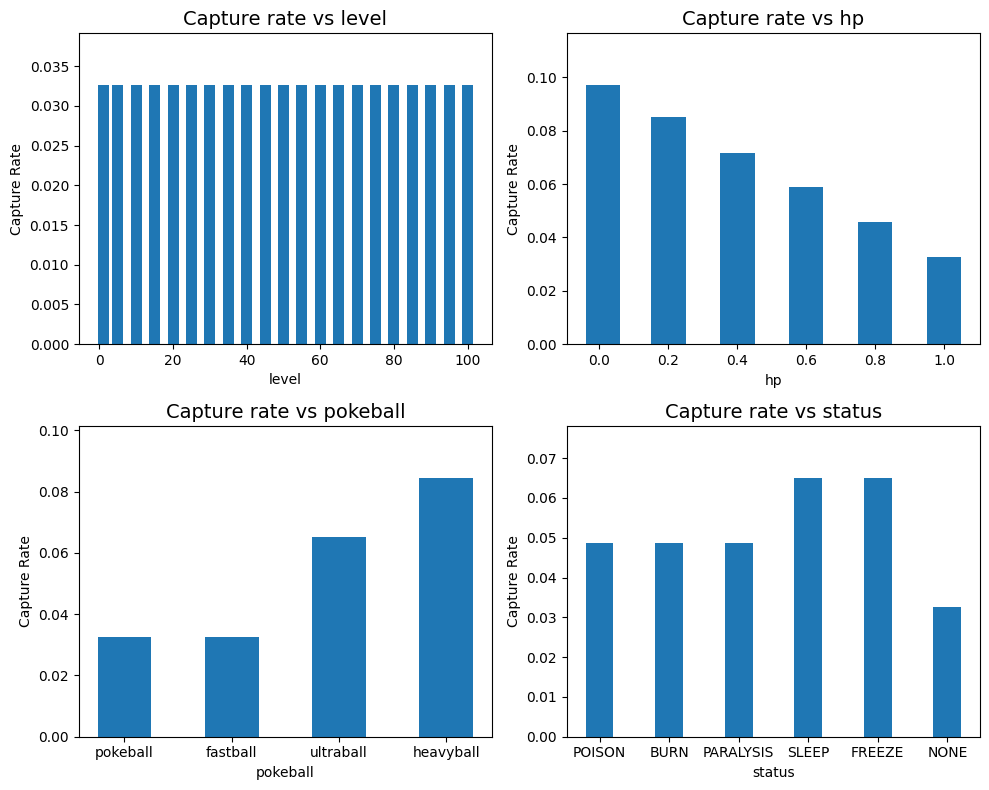

In [17]:

factory = PokemonFactory(get_src_str() + "pokemon.json")
config_ej2c = json.load(open(get_config_dir().joinpath(EJ2_CONFIG), "r"))
variables = ['level', 'hp', 'pokeball', 'status']
plurals_by_variable = {key: value for key, value in zip(variables, ['levels', 'hps', 'pokeballs', 'statuses'])}
widths = [3,0.1,0.5,0.4]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i, (variable, plural) in enumerate(plurals_by_variable.items()):
    values_by_variable = config_ej2c[plural]
    capture_rates = calculate_capture_rates(variable, values_by_variable)
    row, col = divmod(i, 2)
    max_value = max(capture_rates)
    # Plot as a bar chart
    axs[row, col].bar(values_by_variable, capture_rates, align='center', width=widths[i])
    axs[row, col].set_xlabel(variable)
    axs[row, col].set_ylabel('Capture Rate')
    axs[row, col].set_ylim([0, max_value*1.2])
    axs[row, col].set_title(f"Capture rate vs {variable}", fontsize=14)

plt.tight_layout()
plt.show()